In [1]:
import os
import pickle

import pandas as pd
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from definitions import ROOT_DIR

from sklearn import metrics

seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

import simclr_models
import simclr_utitlities

In [2]:
# Dataset-specific
# working_directory = 'SleepEEG/'
# data_folder = 'SleepEEG'
working_directory = 'MIMIC/'
data_folder = 'MIMIC'
model_name = '20230227-170733_finetuning.hdf5'
pretrained_model = tf.keras.models.load_model(os.path.join(working_directory, model_name), compile=False)  # compile=False as we use the model only for inference
pretrained_model.summary()

Model: "base_model_simclrlinear"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 76, 48)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 53, 32)            36896     
_________________________________________________________________
dropout (Dropout)            (None, 53, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 96)            49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 96)

In [3]:
# Load preprocessed data
np_train = (np.load(os.path.join(data_folder, 'train_x.npy')),
           np.load(os.path.join(data_folder, 'train_y.npy')))
np_val = (np.load(os.path.join(data_folder, 'val_x.npy')),
           np.load(os.path.join(data_folder, 'val_y.npy')))
np_test = (np.load(os.path.join(data_folder, 'test_x.npy')),
           np.load(os.path.join(data_folder, 'test_y.npy')))

probs = pretrained_model.predict(np_test[0])
predictions = np.argmax(probs, axis=1)
# print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0]), np_test[1], return_dict=True))

In [34]:
print("Train - Validation - Test Set Shapes:")
print("Train X: {} - Val X: {} - Test X: {}".format(np_train[0].shape, np_val[0].shape, np_test[0].shape))
print("Train y: {} - Val y: {} - Test y: {}".format(np_train[1].shape, np_val[1].shape, np_test[1].shape))

Train - Validation - Test Set Shapes:
Train X: (14681, 76, 48) - Val X: (3222, 76, 48) - Test X: (3236, 76, 48)
Train y: (14681, 2) - Val y: (3222, 2) - Test y: (3236, 2)


In [4]:
os.chdir(ROOT_DIR)
subjects = pd.read_csv(os.path.join('datasets', data_folder, 'demographics_rich.csv'))
subjects.head()

,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,22,NaN,Private,UNOBTAINABLE,WHITE,F,1
1,23,ENGL,Medicare,CATHOLIC,WHITE,M,0
2,24,NaN,Private,PROTESTANT QUAKER,WHITE,M,1
3,25,NaN,Private,UNOBTAINABLE,WHITE,M,1
4,26,NaN,Medicare,CATHOLIC,UNKNOWN/NOT SPECIFIED,M,0


In [5]:
test_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'test_listfile.csv'))
test_listfile.head(20)

,stay,y_true
0,10011_episode1_timeseries.csv,1
1,10026_episode1_timeseries.csv,0
2,10030_episode1_timeseries.csv,0
3,10042_episode1_timeseries.csv,0
4,10094_episode1_timeseries.csv,0
5,10094_episode2_timeseries.csv,1
6,1009_episode1_timeseries.csv,0
7,10102_episode1_timeseries.csv,1
8,10149_episode1_timeseries.csv,0
9,10149_episode2_timeseries.csv,0


In [6]:
# Get subject from test
test_listfile.loc[:, "subject"] = test_listfile.stay.apply(lambda stay: stay.split("_")[0]).astype(int)
test_listfile.head()

,stay,y_true,subject
0,10011_episode1_timeseries.csv,1,10011
1,10026_episode1_timeseries.csv,0,10026
2,10030_episode1_timeseries.csv,0,10030
3,10042_episode1_timeseries.csv,0,10042
4,10094_episode1_timeseries.csv,0,10094


In [7]:
# merge demographics in test df
test_listfile = test_listfile.merge(subjects, left_on="subject", right_on="SUBJECT_ID", how="left")
test_listfile.head()

,stay,y_true,subject,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,10011_episode1_timeseries.csv,1,10011,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,10026_episode1_timeseries.csv,0,10026,10026,NaN,Medicare,OTHER,WHITE,F,0
2,10030_episode1_timeseries.csv,0,10030,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,10042_episode1_timeseries.csv,0,10042,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,10094_episode1_timeseries.csv,0,10094,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0


In [8]:
print("Test rows with null demograpphics: {} ({}%)".format(test_listfile.SUBJECT_ID.isna().sum(), test_listfile.SUBJECT_ID.isna().sum()/test_listfile.shape[0]))
test_listfile.drop(columns=['SUBJECT_ID'], inplace=True)
test_listfile.head()

Test rows with null demograpphics: 0 (0.0%)


,stay,y_true,subject,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,10011_episode1_timeseries.csv,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,10026_episode1_timeseries.csv,0,10026,NaN,Medicare,OTHER,WHITE,F,0
2,10030_episode1_timeseries.csv,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,10042_episode1_timeseries.csv,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,10094_episode1_timeseries.csv,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0


In [9]:
test_listfile.loc[:, "y_predicted"] = predictions
test_listfile.head()

,stay,y_true,subject,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,y_predicted
0,10011_episode1_timeseries.csv,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,0
1,10026_episode1_timeseries.csv,0,10026,NaN,Medicare,OTHER,WHITE,F,0,0
2,10030_episode1_timeseries.csv,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0
3,10042_episode1_timeseries.csv,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,0
4,10094_episode1_timeseries.csv,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,0


In [10]:
# Indicatively testing performance on publicly insured (1 for majority) versus privately insured (0 for minority) subjects
test_listfile_Medicare = test_listfile[test_listfile.INSURANCE == "Medicare"]
test_listfile_Private = test_listfile[test_listfile.INSURANCE == "Private"]
test_listfile_Medicaid = test_listfile[test_listfile.INSURANCE == "Medicaid"]
test_listfile_Government = test_listfile[test_listfile.INSURANCE == "Government"]
test_listfile_Self = test_listfile[test_listfile.INSURANCE == "Self Pay"]

In [11]:
# Overall performance
print("\n--- Train Performance Overall ---")
train_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'train_listfile.csv'))
train_listfile.loc[:, "y_predicted"] = np.argmax(pretrained_model.predict(np_train[0]),axis=1)
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_train[0]), np_train[1], return_dict=True))
print("\n--- Validation Performance Overall ---")
val_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'val_listfile.csv'))
val_listfile.loc[:, "y_predicted"] = np.argmax(pretrained_model.predict(np_val[0]),axis=1)
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_val[0]), np_val[1], return_dict=True))
print("\n--- Test Performance Overall ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0]), np_test[1], return_dict=True))


--- Train Performance Overall ---
{'Accuracy': 0.8633608064845719, 'AUROC': 0.7261825407769059, 'AUPRC': 0.6173800055231677, 'Confusion Matrix': array([[12514,   180],
       [ 1826,   161]], dtype=int64), 'F1 Macro': 0.5320566477697551, 'F1 Micro': 0.8633608064845719, 'F1 Weighted': 0.8192155263708678, 'Precision': 0.6724023198648654, 'Recall': 0.5334233729260677, 'Kappa': 0.10273974647795148}

--- Validation Performance Overall ---
{'Accuracy': 0.8594040968342644, 'AUROC': 0.7272428657046701, 'AUPRC': 0.6152529073304136, 'Confusion Matrix': array([[2732,   54],
       [ 399,   37]], dtype=int64), 'F1 Macro': 0.5319291951053456, 'F1 Micro': 0.8594040968342646, 'F1 Weighted': 0.8174824489320465, 'Precision': 0.6395790412079138, 'Recall': 0.5327398789491362, 'Kappa': 0.09827744491987733}

--- Test Performance Overall ---
{'Accuracy': 0.8788627935723115, 'AUROC': 0.7053460987978191, 'AUPRC': 0.5887859983195709, 'Confusion Matrix': array([[2815,   47],
       [ 345,   29]], dtype=int64),

In [12]:
# Evaluation with bootstrapping
np.random.seed(1234)
rng=np.random.RandomState(1234)

#https://sites.google.com/site/lisaywtang/tech/python/scikit/auc-conf-interval
def get_ci_auc( y_true, y_pred ):
    from scipy.stats import sem
    from sklearn.metrics import roc_auc_score
    n_bootstraps = 500
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        # indices = rng.randint(0, len(y_pred) + 1)

        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

    return confidence_lower,confidence_upper
# overall
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]))
print("Test Set AUC-ROC:\nAUC={} [CI {}-{}]".format(
    simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0]), np_test[1], return_dict=True).get("AUROC"),
    low_CI_binary,
    high_CI_binary
))

C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is dep

Test Set AUC-ROC:
AUC=0.7053460987978191 [CI 0.6781643122536354-0.7351350858892073]


## Performance conditioned on Insurance Type

In [17]:
# Fairness Comparisons conditioned on Insurance Type
print("\n--- Performance on Medicare Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicare"]), np_test[1][test_listfile.INSURANCE == "Medicare"], return_dict=True))
print("\n--- Performance on Private Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Private"]), np_test[1][test_listfile.INSURANCE == "Private"], return_dict=True))
print("\n--- Performance on Medicaid Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicaid"]), np_test[1][test_listfile.INSURANCE == "Medicaid"], return_dict=True))
print("\n--- Performance on Government Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Government"]), np_test[1][test_listfile.INSURANCE == "Government"], return_dict=True))
print("\n--- Performance on Self-Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Self Pay"]), np_test[1][test_listfile.INSURANCE == "Self Pay"], return_dict=True))


--- Performance on Medicare Insured Subjects ---
{'Accuracy': 0.8623226484498161, 'AUROC': 0.7060489244241386, 'AUPRC': 0.6043766871595297, 'Confusion Matrix': array([[1624,   24],
       [ 238,   17]], dtype=int64), 'F1 Macro': 0.5201104951104951, 'F1 Micro': 0.8623226484498161, 'F1 Weighted': 0.8167511482540385, 'Precision': 0.6434072987346414, 'Recall': 0.5260517799352751, 'Kappa': 0.08074073800928494}

--- Performance on Private Insured Subjects ---
{'Accuracy': 0.9038854805725971, 'AUROC': 0.7410183543643758, 'AUPRC': 0.583643725776953, 'Confusion Matrix': array([[876,  16],
       [ 78,   8]], dtype=int64), 'F1 Macro': 0.5472668176893529, 'F1 Micro': 0.9038854805725971, 'F1 Weighted': 0.8784127189380797, 'Precision': 0.6257861635220126, 'Recall': 0.5375430180415058, 'Kappa': 0.11135599118431727}

--- Performance on Medicaid Insured Subjects ---
{'Accuracy': 0.9152542372881356, 'AUROC': 0.6136574074074075, 'AUPRC': 0.5788510044415512, 'Confusion Matrix': array([[212,   4],
      

C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is dep

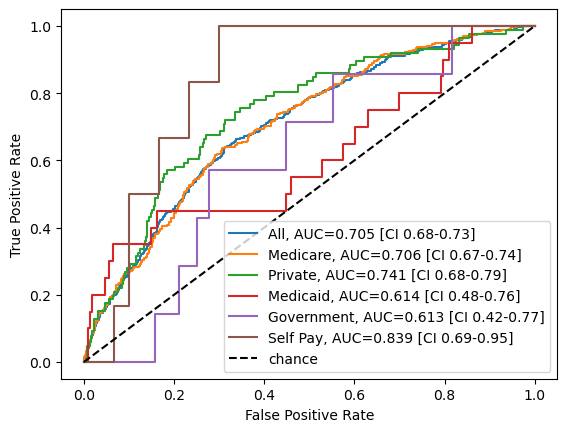

In [16]:
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    pretrained_model.predict(np_test[0])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1], pretrained_model.predict(np_test[0])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]))
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# MEDICARE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == "Medicare"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicare"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == "Medicare"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicare"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.INSURANCE == "Medicare"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicare"]))
plt.plot(fpr, tpr, label="Medicare, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# PRIVATE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == "Private"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Private"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == "Private"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Private"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.INSURANCE == "Private"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Private"]))
plt.plot(fpr, tpr, label="Private, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# MEDICAID
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == "Medicaid"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicaid"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == "Medicaid"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicaid"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.INSURANCE == "Medicaid"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Medicaid"]))
plt.plot(fpr, tpr, label="Medicaid, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# GOVERNMENT
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == "Government"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Government"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == "Government"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Government"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.INSURANCE == "Government"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Government"]))
plt.plot(fpr, tpr, label="Government, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# SELF PAY
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == "Self Pay"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Self Pay"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == "Self Pay"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Self Pay"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.INSURANCE == "Self Pay"], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == "Self Pay"]))
plt.plot(fpr, tpr, label="Self Pay, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

## Performance conditioned on Gender

C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is dep

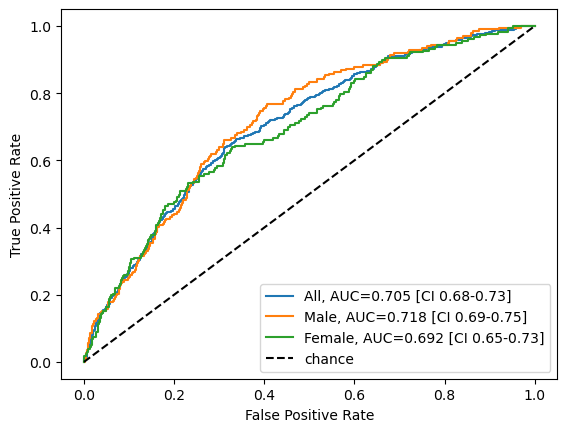

In [18]:
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    pretrained_model.predict(np_test[0])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1], pretrained_model.predict(np_test[0])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]))
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# MALE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.GENDER == "M"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.GENDER == "M"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.GENDER == "M"], pretrained_model.predict(np_test[0][test_listfile.GENDER == "M"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.GENDER == "M"], pretrained_model.predict(np_test[0][test_listfile.GENDER == "M"]))
plt.plot(fpr, tpr, label="Male, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# FEMALE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.GENDER == "F"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.GENDER == "F"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.GENDER == "F"], pretrained_model.predict(np_test[0][test_listfile.GENDER == "F"])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.GENDER == "F"], pretrained_model.predict(np_test[0][test_listfile.GENDER == "F"]))
plt.plot(fpr, tpr, label="Female, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

## Performance conditioned on Ethnicity

In [29]:
test_listfile.ETHNICITY.str.contains("WHITE")

0       False
1        True
2        True
3        True
4       False
        ...  
3231     True
3232     True
3233     True
3234     True
3235    False
Name: ETHNICITY, Length: 3236, dtype: bool

C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is dep

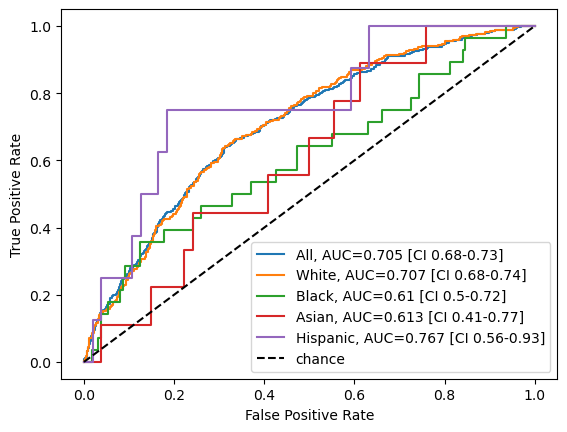

In [30]:
# test_listfile.ETHNICITY.value_counts()[:10].index.tolist()
# test_listfile.ETHNICITY.value_counts()
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    pretrained_model.predict(np_test[0])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1], pretrained_model.predict(np_test[0])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]))
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# WHITE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.ETHNICITY.str.contains("WHITE")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("WHITE")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.ETHNICITY.str.contains("WHITE")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("WHITE")])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.ETHNICITY.str.contains("WHITE")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("WHITE")]))
plt.plot(fpr, tpr, label="White, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# BLACK
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.ETHNICITY.str.contains("BLACK")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("BLACK")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.ETHNICITY.str.contains("BLACK")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("BLACK")])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.ETHNICITY.str.contains("BLACK")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("BLACK")]))
plt.plot(fpr, tpr, label="Black, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# ASIAN
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.ETHNICITY.str.contains("ASIAN")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("ASIAN")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.ETHNICITY.str.contains("ASIAN")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("ASIAN")])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.ETHNICITY.str.contains("ASIAN")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("ASIAN")]))
plt.plot(fpr, tpr, label="Asian, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# HISPANIC/LATINO
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.ETHNICITY.str.contains("HISPANIC")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("HISPANIC")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.ETHNICITY.str.contains("HISPANIC")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("HISPANIC")])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.ETHNICITY.str.contains("HISPANIC")], pretrained_model.predict(np_test[0][test_listfile.ETHNICITY.str.contains("HISPANIC")]))
plt.plot(fpr, tpr, label="Hispanic, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

## Performance conditioned on Age

C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 3235 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
C:\Users\syfan\AppData\Local\Temp\ipykernel_13416\3971497997.py:13: DeprecationWarning: This function is dep

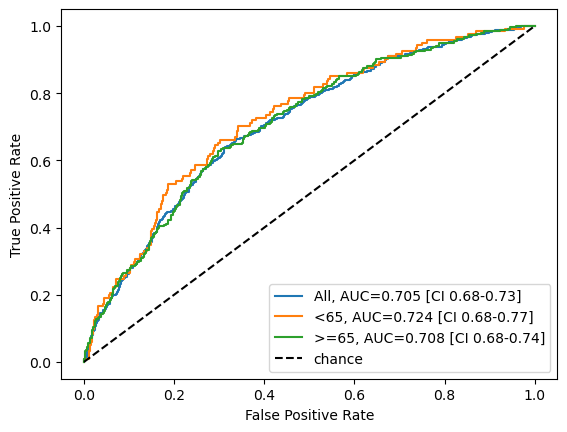

In [31]:
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    pretrained_model.predict(np_test[0])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1], pretrained_model.predict(np_test[0])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]))
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# <65 (1)
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.AGE == 1][:,1],
    pretrained_model.predict(np_test[0][test_listfile.AGE == 1])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.AGE == 1], pretrained_model.predict(np_test[0][test_listfile.AGE == 1])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.AGE == 1], pretrained_model.predict(np_test[0][test_listfile.AGE == 1]))
plt.plot(fpr, tpr, label="<65, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# >=65 (0)
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.AGE == 0][:,1],
    pretrained_model.predict(np_test[0][test_listfile.AGE == 0])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.AGE == 0], pretrained_model.predict(np_test[0][test_listfile.AGE == 0])), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.AGE == 0], pretrained_model.predict(np_test[0][test_listfile.AGE == 0]))
plt.plot(fpr, tpr, label=">=65, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))


plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

## Performance conditioned on Marital Status

In [33]:
# todo